# Model Evaluation

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

## Import Data

In [2]:
X_val = pd.read_hdf("data/classifier/validation.h5", key="X")
y_val = pd.read_hdf("data/classifier/validation.h5", key="y").values

In [4]:
# Remove samples and weights from X_val
val_samples = X_val["Sample"].values
val_weights = X_val["gen_weights"].values
X_val.drop(["Sample", "gen_weights"], axis=1, inplace=True)

## Import model

In [5]:
def load_model(study_df, best=True, name=None):
    """
    Automatically loads model of a specified optuna study
    
    study_df -> pandas dataframe: study dataframe
    best -> bool: select best model of study
    name -> string: model name to load. Gets overwritten by input best.
    
    return -> keras model
    """
    
    if best: name = "trial_" + str(study_df["val_acc"].argmax())
    model = keras.models.load_model("models/" + name + ".h5")
    print("Best Model:", name)
        
    return model

In [6]:
name, best = "trial_18", True
study_df = pd.read_hdf("optuna_studies/study_1.h5", key="study")

model = load_model(study_df, best, name)

Best Model: trial_6


# Metrics 

In [7]:
y_preds = model.predict(X_val.values)

In [8]:
print("Model Accuracy:", accuracy_score(y_preds.round(), y_val))

Model Accuracy: 0.8622250735795166


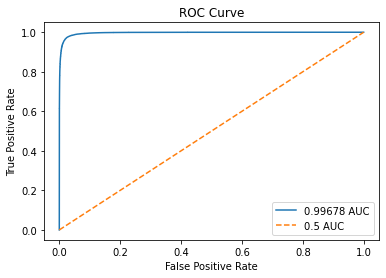

In [9]:
fpr, tpr, thr = roc_curve(y_val, y_preds, sample_weight=val_weights)

roc_auc = roc_auc_score(y_val, y_preds, sample_weight=val_weights)
plt.title("ROC Curve")
plt.plot(fpr, tpr, label=f"{roc_auc:.5f} AUC")
plt.plot([0, 1], [0, 1], "--", label="0.5 AUC")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

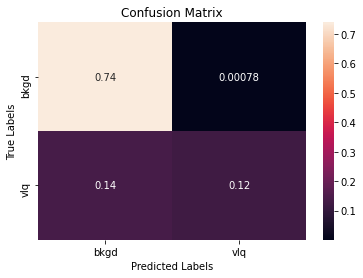

In [10]:
cm = confusion_matrix(y_val, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

In [11]:
# Round function threshold sensitive
def costum_round(value, threshold):
    if value > threshold:
        return 1
    else:
        return 0

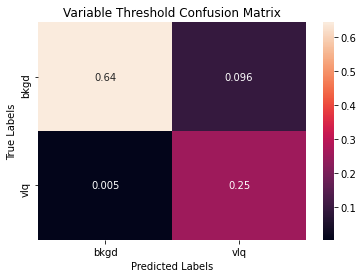

In [12]:
# Get optimal threshold
optim_thr = thr[np.argmax(tpr - fpr)]

# Get confusion matrix
cm = confusion_matrix(y_val, [costum_round(y_preds[i], optim_thr) for i in range(len(y_preds))], normalize="all")

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Variable Threshold Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

# Predicted vs True distributions

## Bkgd Pred vs True

In [13]:
# Predictions with optimal threshold
y_preds = np.array([costum_round(y_preds[i], optim_thr) for i in range(len(y_preds))])

Plotting: 100%|██████████| 69/69 [01:11<00:00,  1.04s/it]


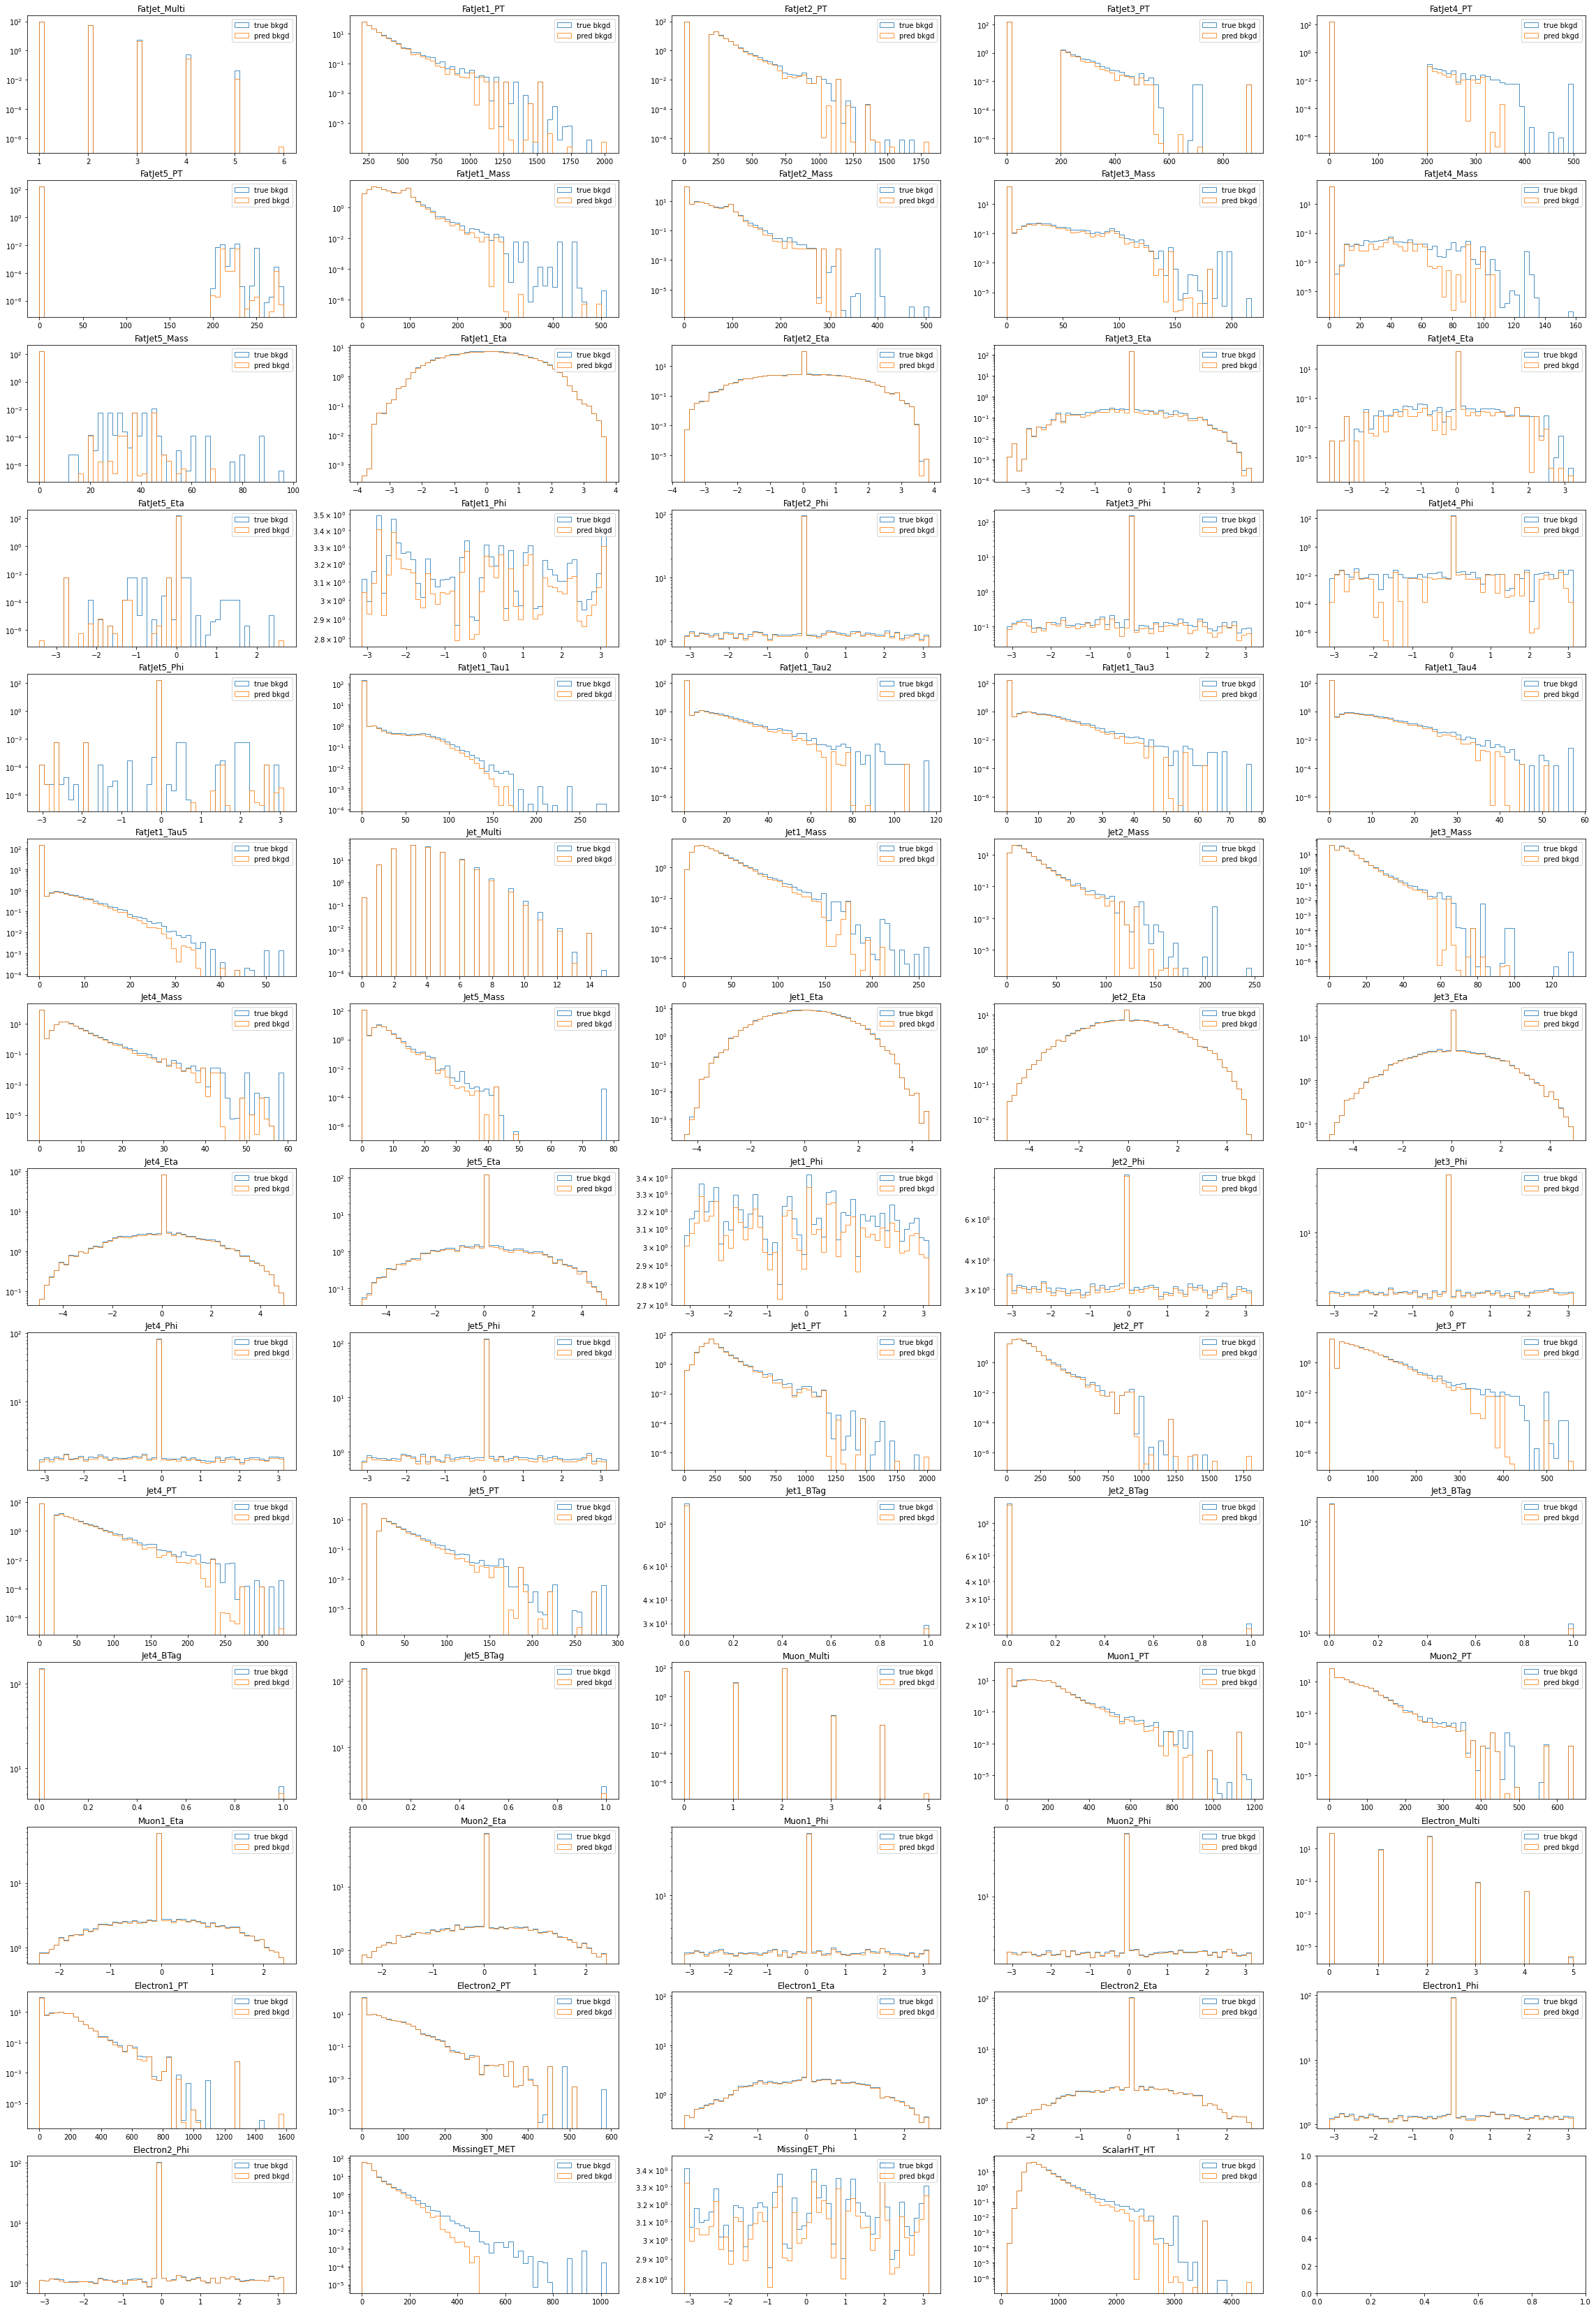

In [14]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(X_val.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
for i, column in tqdm(enumerate(X_val.columns), total=len(list(X_val.columns)), desc="Plotting"):
        # Define histogram range
        hist_min = min(X_val[y_val == 0][column].min(), X_val[y_preds == 0][column].min())
        hist_max = max(X_val[y_val == 0][column].max(), X_val[y_preds == 0][column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(X_val.columns[i])
        axs[row, col].hist(X_val[y_val == 0][column], bins=50, label="true bkgd", alpha=0.8, range=hist_range,
                           weights=val_weights[y_val == 0], histtype='step')
        axs[row, col].hist(X_val[y_preds == 0][column], bins=50, label="pred bkgd", alpha=0.8, range=hist_range,
                           weights=val_weights[y_preds == 0], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/True_vs_Pred_BKGD_distributions.png", dpi=500)
plt.show()

## VLQ Pred vs True

Plotting: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s]


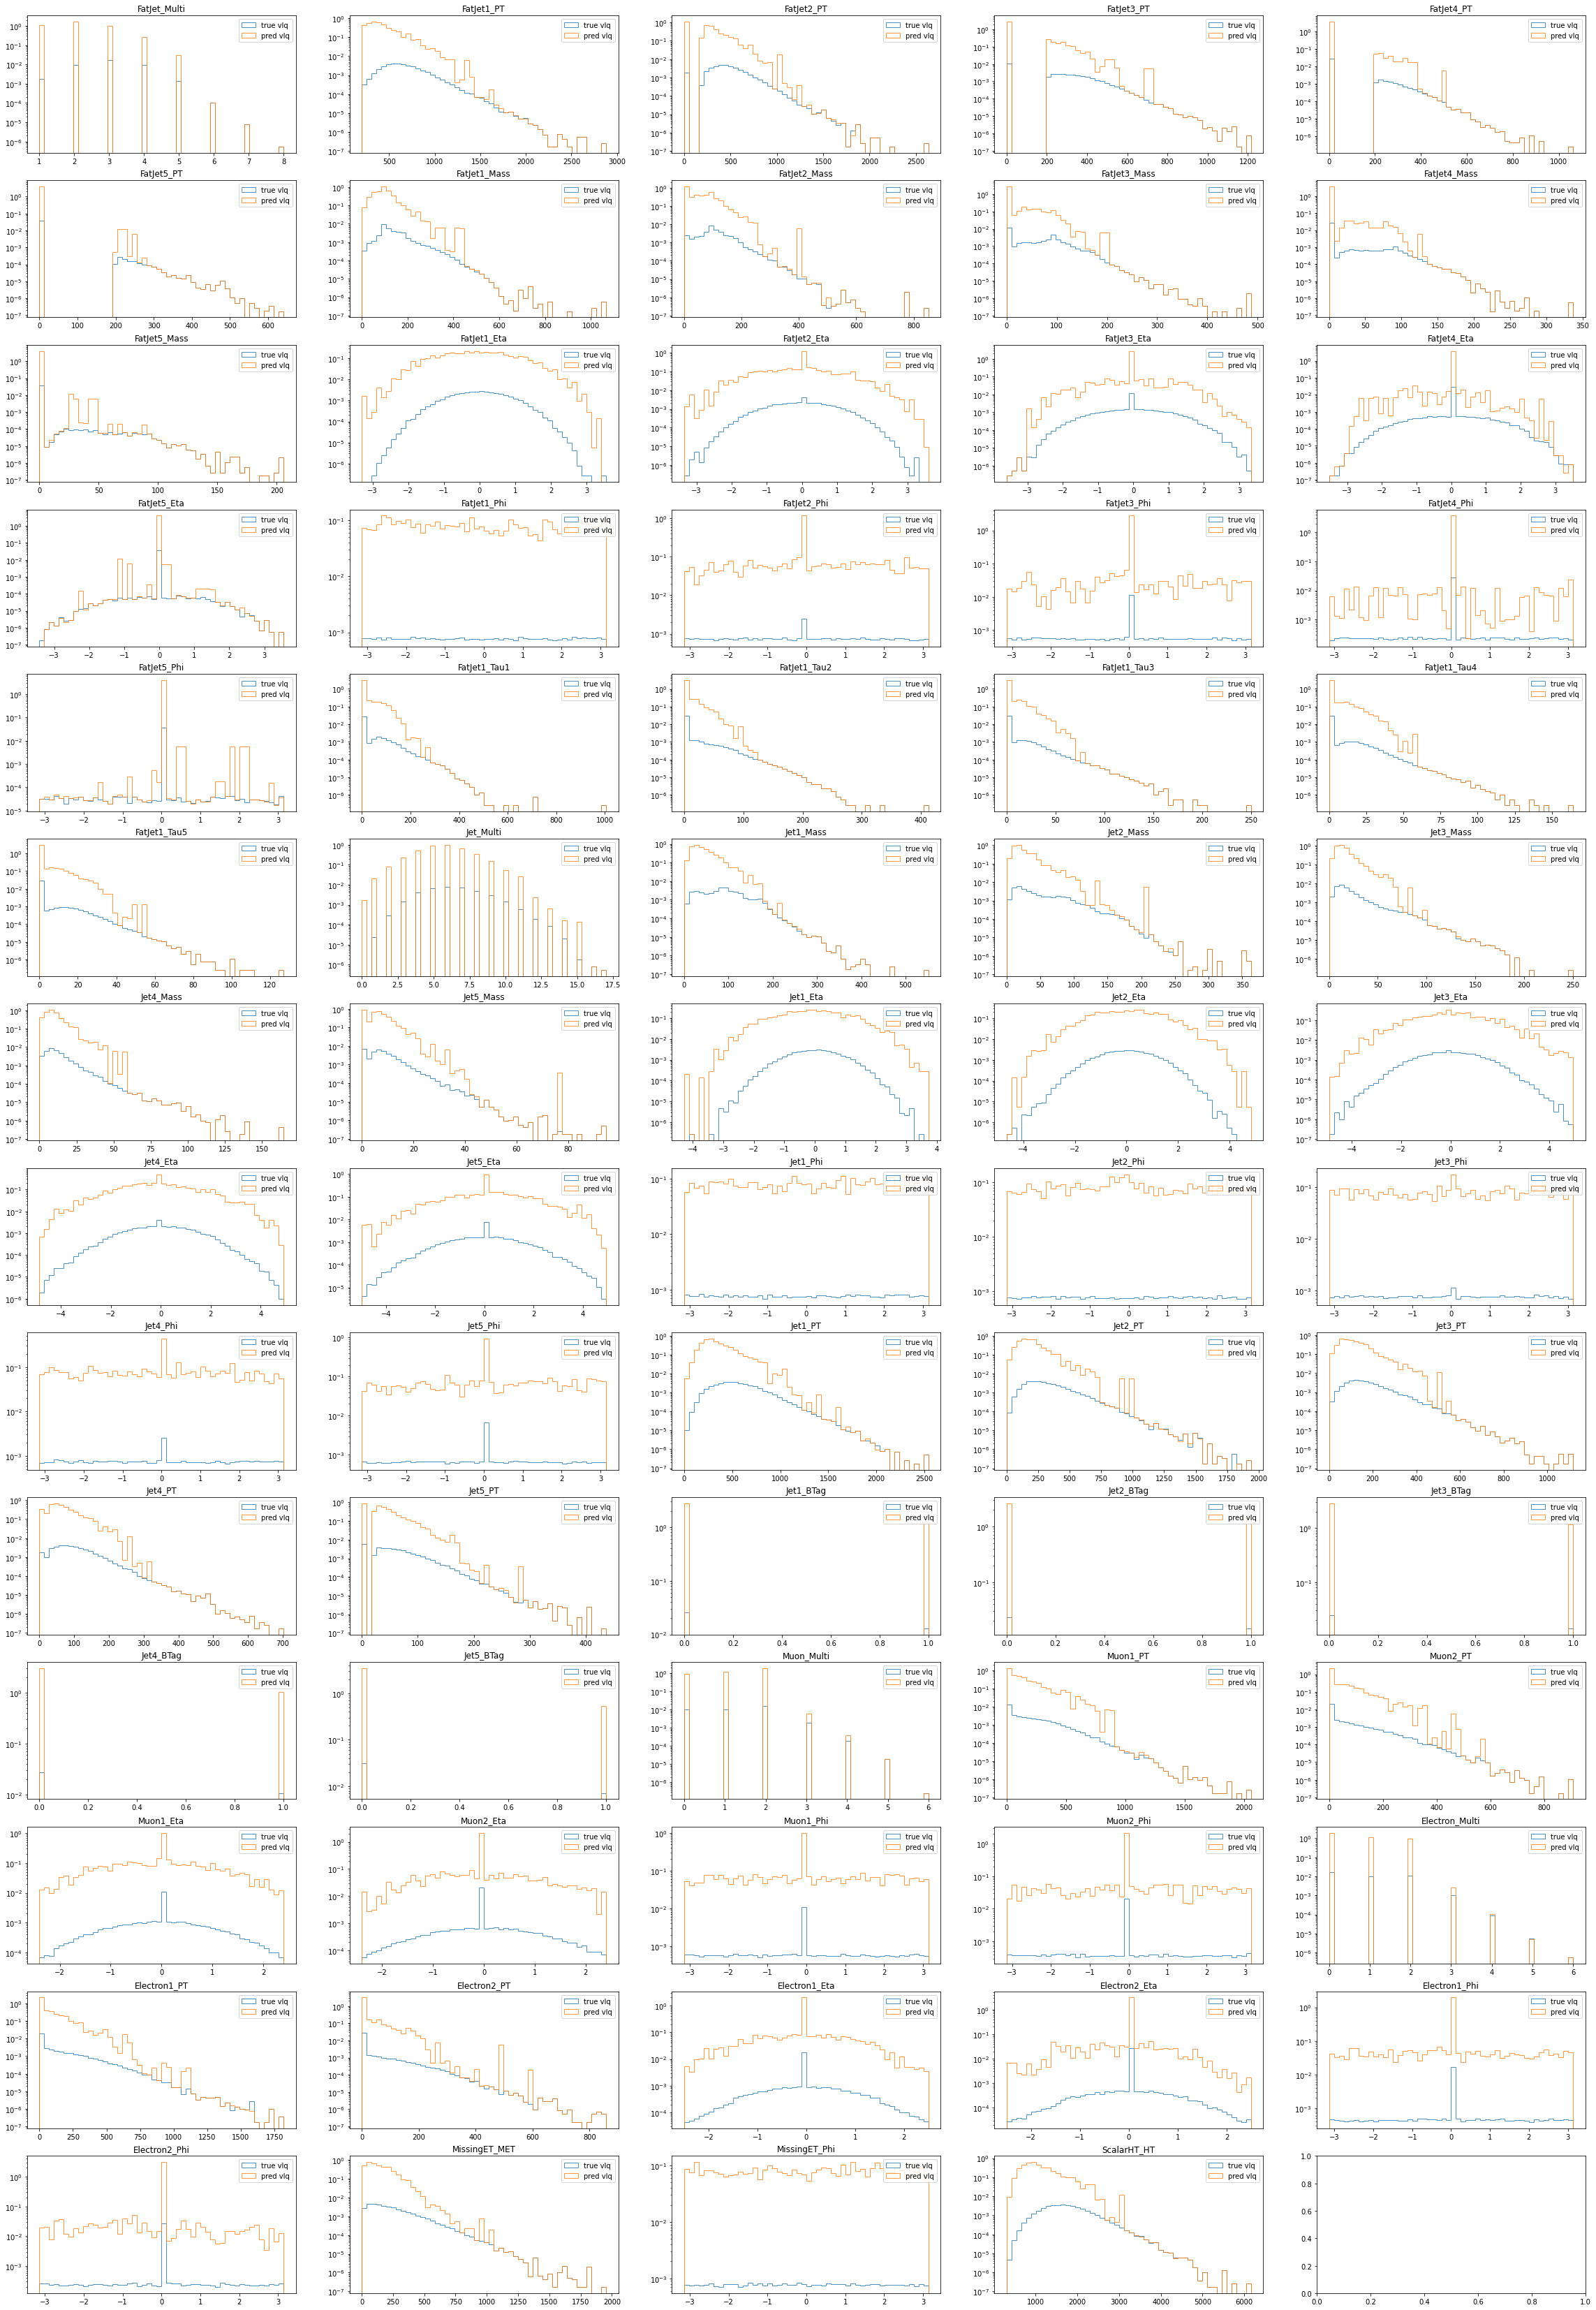

In [15]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(X_val.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
for i, column in tqdm(enumerate(X_val.columns), total=len(list(X_val.columns)), desc="Plotting"):
        # Define histogram range
        hist_min = min(X_val[y_val == 1][column].min(), X_val[y_preds == 1][column].min())
        hist_max = max(X_val[y_val == 1][column].max(), X_val[y_preds == 1][column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(X_val.columns[i])
        axs[row, col].hist(X_val[y_val == 1][column], bins=50, label="true vlq", alpha=0.8, range=hist_range,
                           weights=val_weights[y_val == 1], histtype='step')
        axs[row, col].hist(X_val[y_preds == 1][column], bins=50, label="pred vlq", alpha=0.8, range=hist_range,
                           weights=val_weights[y_preds == 1], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/True_vs_Pred_VLQ_distributions.png", dpi=500)
plt.show()

# MCDropout

In [16]:
num_models = 100
mcpreds = []

for _ in tqdm(range(num_models), total=num_models, desc="MCDropout"):
    mcpreds.append(model.predict(X_val))
    
mcpreds = np.array(mcpreds)

MCDropout: 100%|██████████| 100/100 [05:14<00:00,  3.15s/it]


In [17]:
mc_means = mcpreds.mean(axis=0)
mc_stds = mcpreds.std(axis=0)

In [18]:
print("MCDropout Accuracy:", accuracy_score(mc_means.round(), y_val))

MCDropout Accuracy: 0.8629282472851696


MCDropout AUC Score: 0.9969468573864313


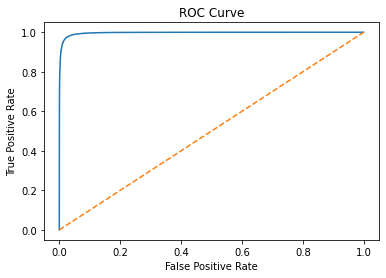

In [19]:
fpr, tpr, thr = roc_curve(y_val, mc_means, sample_weight=val_weights)

print("MCDropout AUC Score:", roc_auc_score(y_val, mc_means, sample_weight=val_weights))
plt.title("ROC Curve")
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

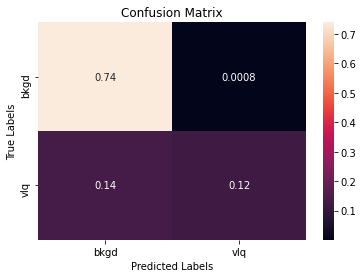

In [20]:
cm = confusion_matrix(y_val, mc_means.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

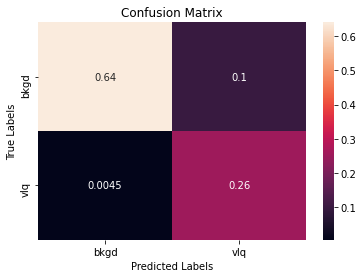

In [21]:
# Get best threshold
mc_thr = thr[np.argmax(tpr - fpr)]

# Calculate confusion matrix
cm = confusion_matrix(y_val, [costum_round(mc_means[i], mc_thr) for i in range(len(mc_means))], normalize="all")

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

# MCDropout STDs by class

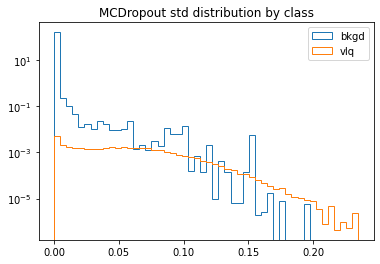

In [22]:
hist_min = min(mc_stds[y_val == 0].min(), mc_stds[y_val == 1].min())
hist_max = max(mc_stds[y_val == 0].max(), mc_stds[y_val == 1].max())
hist_range = (hist_min, hist_max)

plt.title("MCDropout std distribution by class")
plt.hist(mc_stds[y_val == 0], label="bkgd", bins=50, range=hist_range, histtype="step", weights=val_weights[y_val == 0])
plt.hist(mc_stds[y_val == 1], label="vlq", bins=50, range=hist_range, histtype="step", weights=val_weights[y_val == 1])
plt.yscale("log")
plt.legend()
plt.savefig("plots/mcdropout_std_distribution_by_class.png", dpi=500)
plt.show()

# MCDropout STDs by sample

In [48]:
# Gather bkgd samples
bkgd_samples = glob("data/dileptonic/*.csv")
bkgd_samples = [sample.split("/")[-1].split(".")[0] + "_BKGD" for sample in bkgd_samples]

# Gather VLQ samples
vlq_samples = glob("data/sm_gluon_vlq/*.csv")
vlq_samples = [sample.split("/")[-1].split(".")[0] + "_VLQ" for sample in vlq_samples]

# Concatenate
samples = bkgd_samples + vlq_samples

In [50]:
# Remove test and train from sample names
for i, sample in enumerate(samples):
    if "test" in sample: samples[i] = samples[i].replace("_test", "")
    elif "train" in sample: samples[i] = samples[i].replace("_train", "")

# Remove duplicates
samples = list(dict.fromkeys(samples))

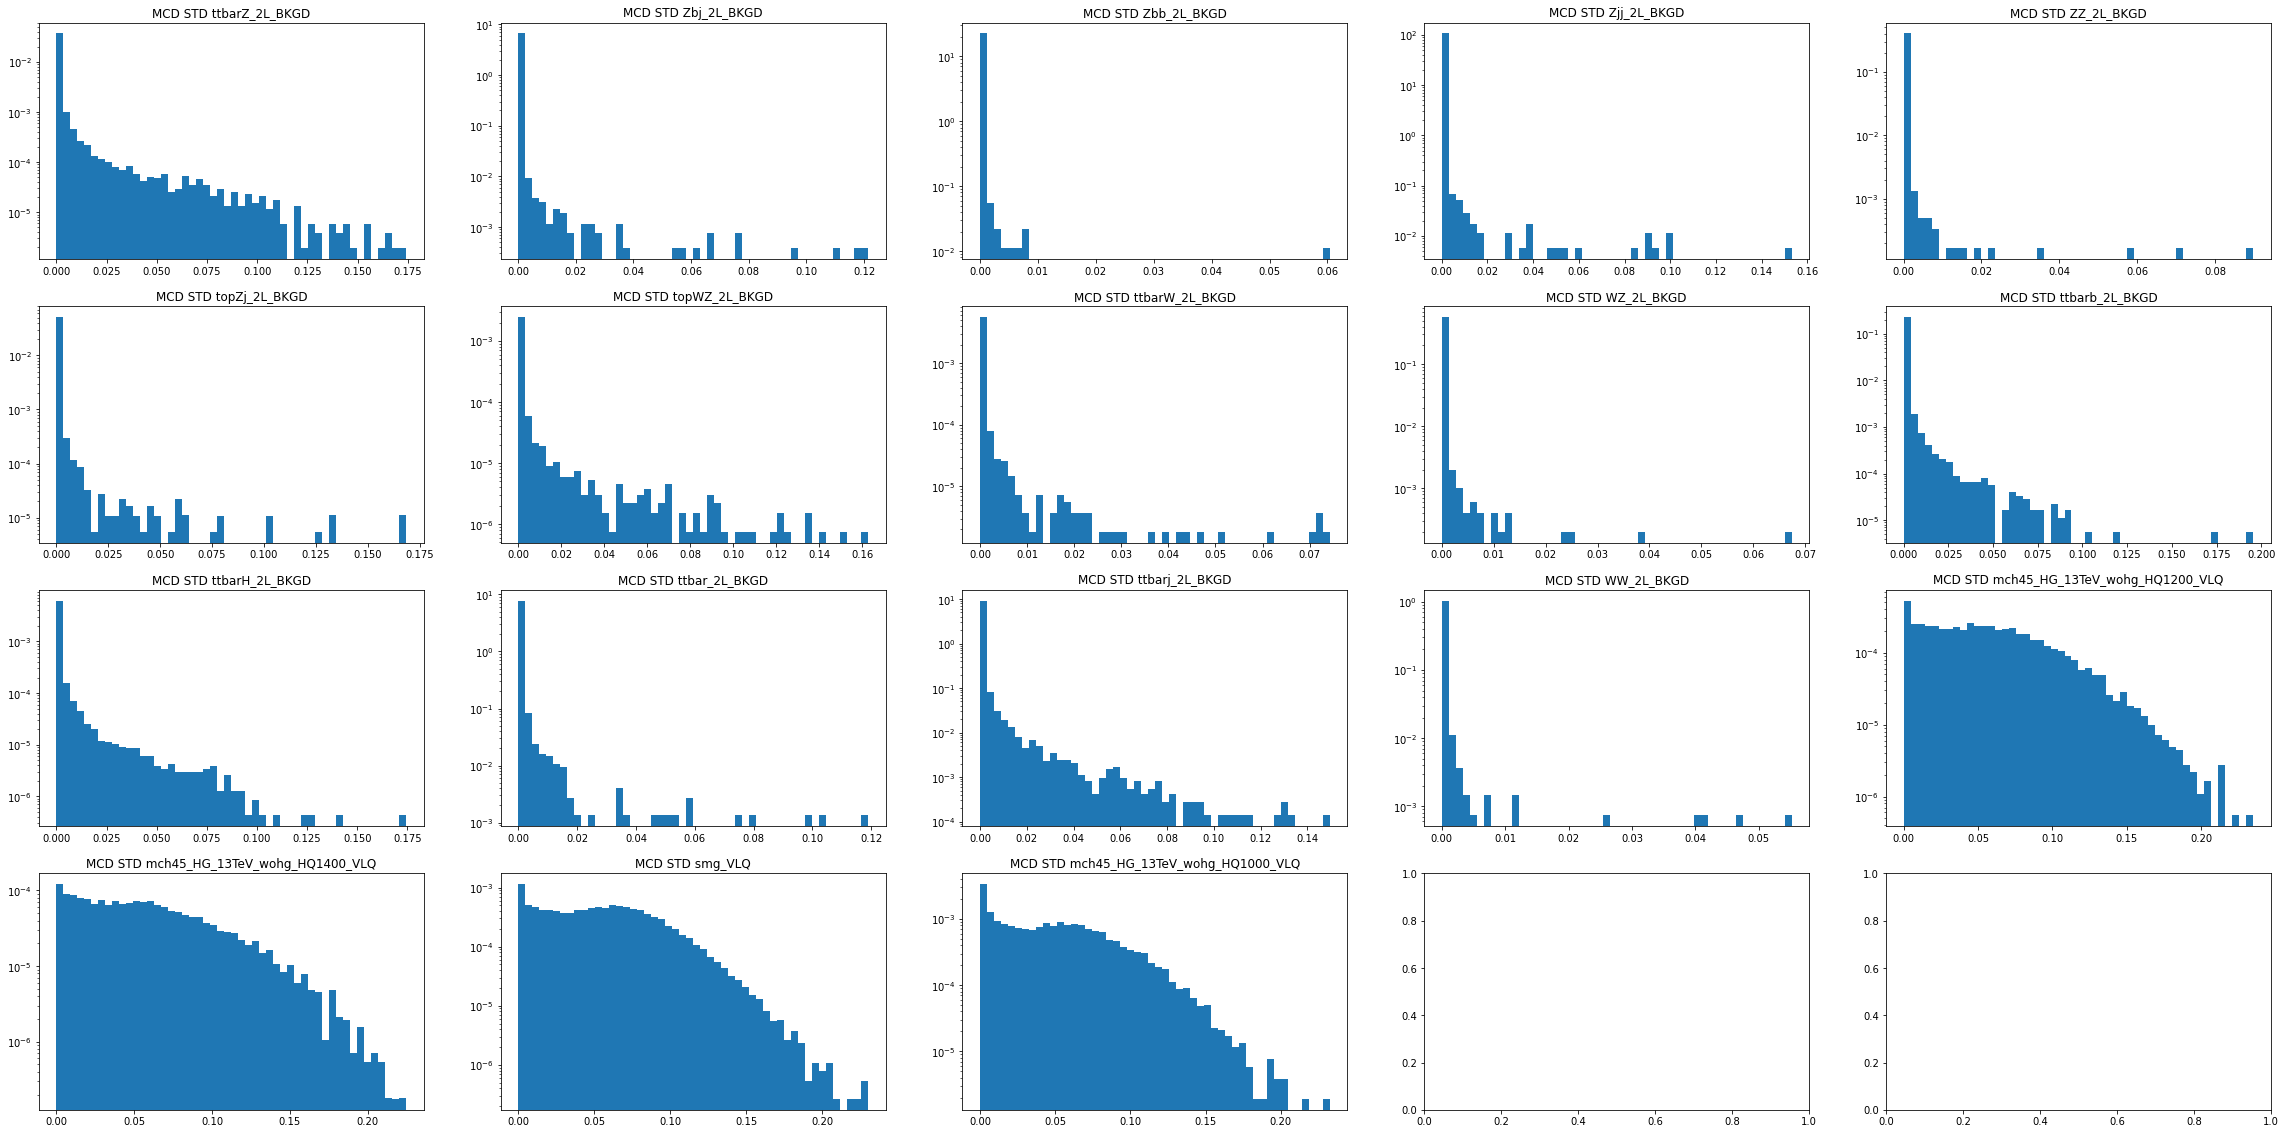

In [53]:
# Plot adjustment variables
num_cols, bins = 5, 50

# Generate the plots
num_rows = int(np.ceil((len(samples)) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 20))

# Iterate and generate each data
for i, sample in enumerate(samples):
    # Plot the data
    row, col = int(i/num_cols), i%num_cols
    axs[row, col].set_title("MCD STD " + sample)
    sample = sample.replace("_BKGD", "").replace("_VLQ", "")
    axs[row, col].hist(mc_stds[val_samples == sample], bins=50, weights=val_weights[val_samples == sample])
    axs[row, col].set_yscale("log")
    
plt.savefig("plots/stds_distribution_mcd_per_sample.png", dpi=500)
plt.show()

# Std vs Means plot

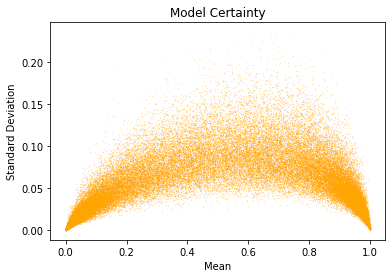

In [54]:
plt.title("Model Certainty")
plt.scatter(mc_means, mc_stds, s=0.01, color='orange')
plt.ylabel("Standard Deviation")
plt.xlabel("Mean")
plt.show()